# tRNA

In [121]:
import pandas as pd 

df = pd.read_csv("../../outputs/ForLatent/RF00005/tsne_with_codon_phylogeny.csv")

from collections import Counter
import numpy as np 
from pprint import pprint 

phy = {p for p in Counter(df["phylum"]) if (Counter(df["phylum"])[p] > 150) & (p is not np.nan)}
codon = {c for c in Counter(df["anticodon"]) if (Counter(df["anticodon"])[c] > 150) & (c != "---")}
pprint(phy)
pprint(codon)


{'Proteobacteria', 'Chordata', 'Firmicutes', 'Arthropoda', 'Streptophyta'}
{'GCA', 'UGU', 'AGC', 'UGC', 'CGU'}


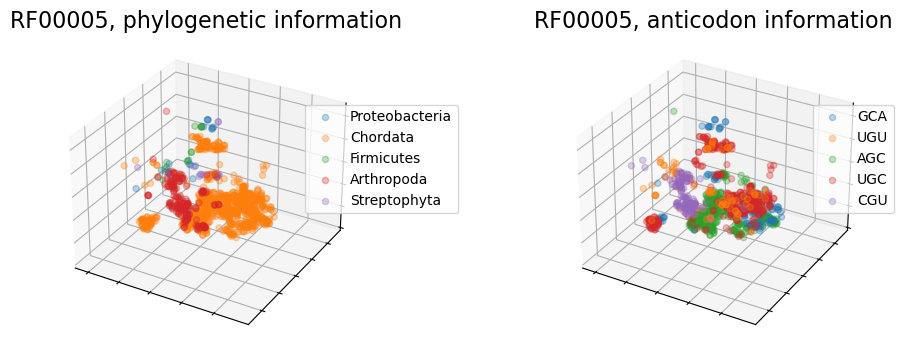

In [122]:
# 3d scatter plot by matplotlib
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "sans-serif"
from mpl_toolkits.mplot3d import Axes3D
df_data = df[df["anticodon"].isin(codon) & df["phylum"].isin(phy)]

fig = plt.figure(figsize=(12, 4))

# fig of phylogeny
ax1 = fig.add_subplot(121, projection='3d')
for p in phy:
    df_data_p = df_data[df_data["phylum"] == p]
    ax1.scatter(
        df_data_p["0"],
        df_data_p["1"],
        df_data_p["2"], label = p, alpha = 0.3)
ax1.set_title("RF00005, phylogenetic information", fontsize = 16, fontfamily = "sans-serif")
ax1.legend(loc = "upper left", bbox_to_anchor=(0.8,0.8))
ax1.set_xticklabels([])
ax1.set_yticklabels([])
ax1.set_zticklabels([])

# fig of codon
ax2 = fig.add_subplot(122, projection='3d')
for c in codon:
    df_data_c = df_data[df_data["anticodon"] == c]
    ax2.scatter(
        df_data_c["0"],
        df_data_c["1"],
        df_data_c["2"], label = c, alpha = 0.3)
ax2.set_title("RF00005, anticodon information", fontsize = 16, fontfamily = "sans-serif")
ax2.legend(loc = "upper left", bbox_to_anchor=(0.8,0.8))
ax2.set_xticklabels([])
ax2.set_yticklabels([])
ax2.set_zticklabels([])
# fig.savefig("../../outputs/figures/suppfigure4a.png", dpi = 600, transparent = True)
fig.savefig("../../outputs/figures/suppfigure4a.pdf", transparent = True)


# RF00001/RF00003/RF00004/RF00059

In [45]:
from Bio import SeqIO
from sklearn.model_selection import train_test_split
import h5py 

rfam = "RF00001"

log_dir = f"../../outputs/ForFigure2/{rfam}"
data_dir = f"../../datasets/ForFigure2/{rfam}"


h = !ls {data_dir}/*cm*train.h5
f = !ls {data_dir}/*_seqonly.fa

print(f)
print(h)

['../../datasets/ForFigure2/RF00001/RF00001_unique_seed_removed_106ntTO123nt_refoldSScons_g3parsable_seqonly.fa']
['../../datasets/ForFigure2/RF00001/RF00001_unique_seed_removed_106ntTO123nt_refoldSScons_g3parsable_seqonly_notrunc_traceback_onehot_cm_train.h5']


In [46]:
records_iddesc = [(record.id, record.description) for record in SeqIO.parse(f[0], "fasta")]
train_iddesc, _ = train_test_split(records_iddesc, test_size=0.3, random_state = 42)
train_iddesc
data = h5py.File(h[0], "r+")

if "id" in dict(data):
    del data["id"]
if "desc" in dict(data):
    del data["desc"]
    
# add id and desc
data.create_dataset("id", data=[x[0].encode() for x in train_iddesc])
data.create_dataset("desc", data=[x[1].encode() for x in train_iddesc])

data["desc"][:3]

array([b'ALWZ042669538.1/6958-7078 ALWZ042669538.1/6958-7078 Picea glauca, whole genome shotgun sequence.',
       b'MJEQ01002079.1/61932-61825 MJEQ01002079.1/61932-61825 Nicotiana attenuata strain UT scaffold02079, whole genome shotgun sequence.',
       b'ALWS01061720.1/30405-30287 ALWS01061720.1/30405-30287 Pteropus alecto contig61720, whole genome shotgun sequence.'],
      dtype=object)

In [47]:
import pytaxonkit
import h5py

In [48]:
!ls {log_dir}/CMVAE*/*pt

../../outputs/ForFigure2/RF00001/CMVAE/model_epoch33_cmvae.pt


In [49]:
# load z_train with desc
import torch
import sys 
sys.path.append("../../src")
from models.CMVAE import CovarianceModelVAE

model = CovarianceModelVAE.build_from_config(f"{log_dir}/CMVAE/config_cmvae.yaml")

pt = !ls {log_dir}/CMVAE*/*pt

model.load_model_from_ckpt(pt[0])
model.eval();

def load_data_cm(path):
    data = h5py.File(path, "r")
    id_ = data["id"][:].tolist()
    desc = data["desc"][:].tolist()
    tr = torch.from_numpy(data["tr"][:]).nan_to_num(0).transpose(-2, -1).float()
    s = torch.from_numpy(data["s"][:]).transpose(-2, -1).float()
    p = torch.from_numpy(data["p"][:]).transpose(-2, -1).float()
    return id_, desc, tr, s, p


X_train_fname = h[0]
pentad = load_data_cm(X_train_fname)


z_mu_train = []
z_logvar_train = []
z_id_train = []
z_desc_train = []

for id_, desc, tr_, s_, p_ in zip(*pentad):
    tr_ = tr_.unsqueeze(0)
    s_ = s_.unsqueeze(0)
    p_ = p_.unsqueeze(0)
    mu, logvar = model.encoder((tr_, s_, p_))
    z_mu_train.append(mu.squeeze().detach().numpy())
    z_logvar_train.append(logvar.squeeze().detach().numpy())
    z_id_train.append(id_.decode())
    z_desc_train.append(desc.decode())
len(z_desc_train)

62897

In [ ]:
train_name = [" ".join(line.split(" ")[2:4]) for line in z_desc_train];
train_name[:5]

['Picea glauca,',
 'Nicotiana attenuata',
 'Pteropus alecto',
 'Picea glauca,',
 'Picea glauca,']

In [51]:
df_train = pytaxonkit.name2taxid(train_name)
df_train_lineage = pytaxonkit.lineage(df_train.TaxID)
df_train_lineage.head(2)

,TaxID,Code,Name,Lineage,LineageTaxIDs,Rank,FullLineage,FullLineageTaxIDs,FullLineageRanks
0,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,49451.0,49451,Nicotiana attenuata,Eukaryota;Streptophyta;Magnoliopsida;Solanales...,2759;35493;3398;4069;4070;4085;49451,species,cellular organisms;Eukaryota;Viridiplantae;Str...,131567;2759;33090;35493;131221;3193;58023;7853...,no rank;superkingdom;kingdom;phylum;subphylum;...


In [55]:
from pprint import pprint
from collections import Counter

df_train_lineage["phylum"] = [l.split(";")[1] if type(l) == str else "" for l in df_train_lineage.Lineage]
df_train_lineage.head(2)
# df_train_lineage_　= df_train_lineage.iloc[:10000]

# pprint(Counter(df_train_lineage["phylum"]))
class200 = [k for k,v in Counter(df_train_lineage["phylum"]).items() if v>=1000 and k!=""]
class200

['Streptophyta',
 'Chordata',
 'Ascomycota',
 'Arthropoda',
 'Firmicutes',
 'Proteobacteria']

In [56]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np

# pca = PCA(n_components=2)
tsne = TSNE(n_components=2, random_state = 42)
train_z = np.vstack(z_mu_train)
z_tsne = tsne.fit_transform(train_z)
z_tsne.shape

(62897, 2)

In [57]:
z_embed = z_tsne
df = pd.DataFrame(z_embed)
df["phylum"] = df_train_lineage["phylum"]

df.head(3)

,0,1,phylum
0,16.052303,95.877861,
1,37.035927,72.710983,Streptophyta
2,-52.450573,15.275131,Chordata


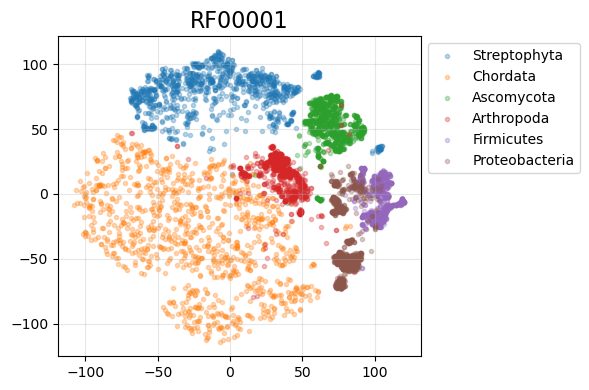

In [60]:
plt.figure(figsize = (6, 4))
for p in class200:
    if p!="---":
        data = df[df["phylum"] == p].sample(1000, random_state = 42)
        plt.scatter(data[0], data[1], label = p, marker = ".", alpha = 0.3)
plt.legend(loc = "upper left", bbox_to_anchor=(1.0,1.0))
plt.grid(alpha = 0.3)
plt.xlabel("")
plt.ylabel("")
plt.title(f"{rfam}", fontsize = 16)
# plt.xlim(-70, 120)
plt.tight_layout()
plt.savefig(f"../../outputs/figures/figure3a_{rfam}.pdf", transparent = True)
plt.show()

